<a href="https://colab.research.google.com/github/anhduong77/Wildfire_Assessment_Via_Remote_Sensing/blob/main/notebook/1_Engineering_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rasterio -q > /dev/null
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# EDA & data quality

In [ ]:
img_paths = sorted(glob.glob("/content/drive/MyDrive/EarthEngine/images/image_*.tif"))
ms_paths = sorted(glob.glob("/content/drive/MyDrive/EarthEngine/images/mask_*.tif"))

In [ ]:
with rasterio.open(img_paths[0]) as src:
  print(src.read().shape)

(15, 810, 1214)


(810, 1214)
(810, 1214)
(810, 1214)
(810, 1214, 3)
(810, 1214)
(810, 1214)
(810, 1214)
(810, 1214, 3)
(702, 1321)
(702, 1321)
(702, 1321)
(702, 1321, 3)
(702, 1321)
(702, 1321)
(702, 1321)
(702, 1321, 3)
(922, 868)
(922, 868)
(922, 868)
(922, 868, 3)
(922, 868)
(922, 868)
(922, 868)
(922, 868, 3)
(1125, 1071)
(1125, 1071)
(1125, 1071)
(1125, 1071, 3)
(1125, 1071)
(1125, 1071)
(1125, 1071)
(1125, 1071, 3)


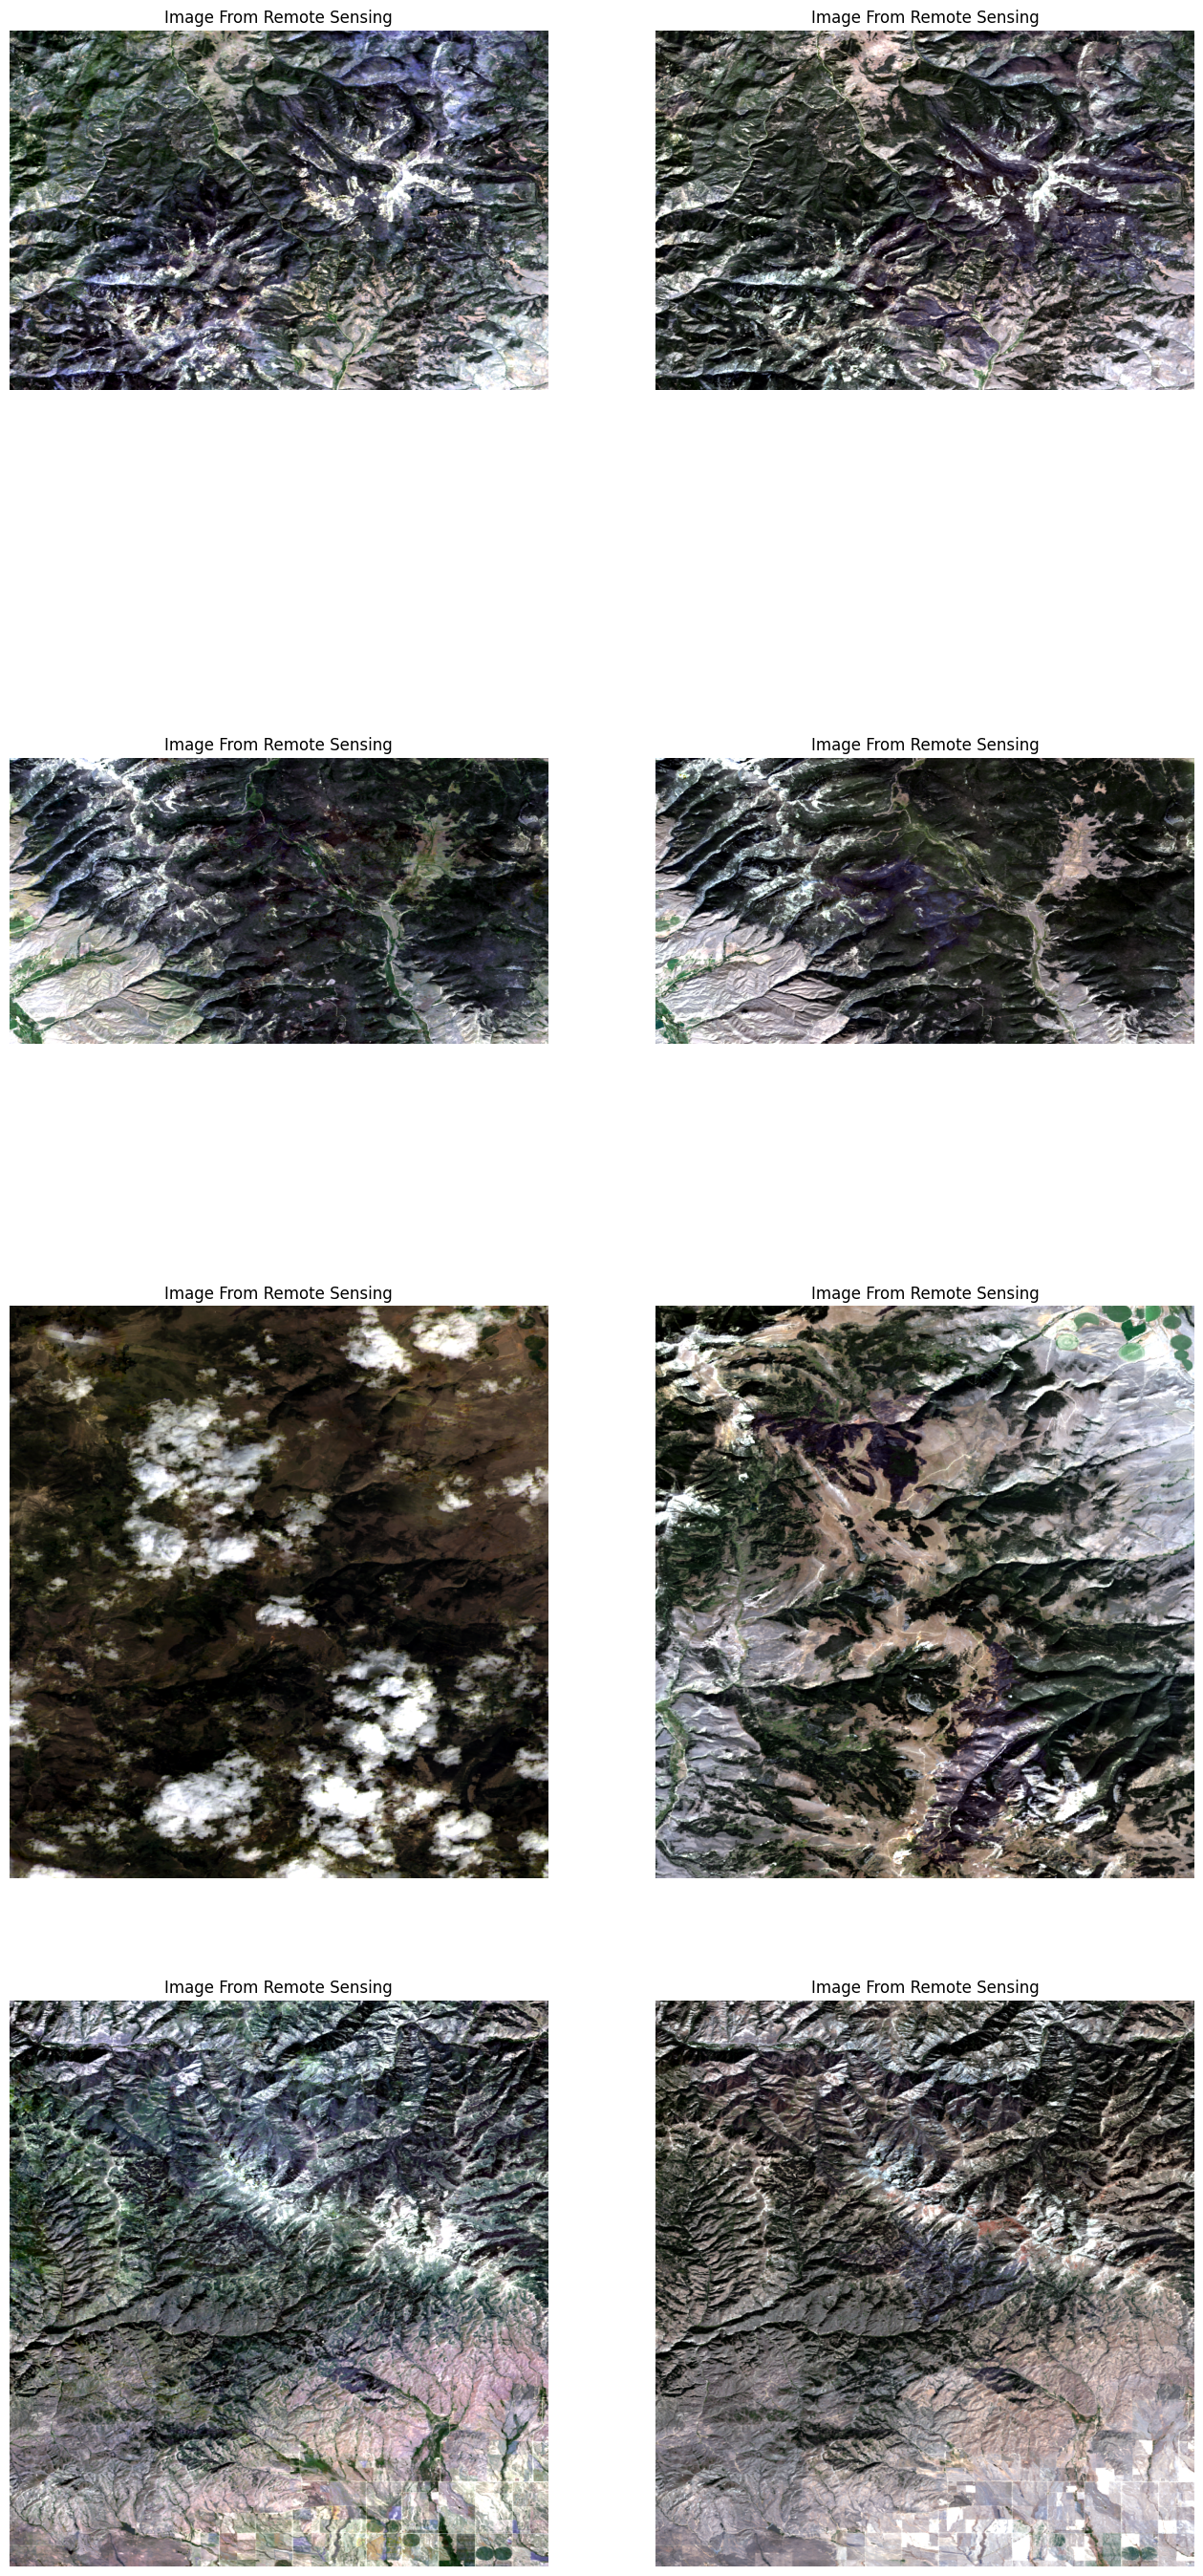

In [ ]:
def show_img(path, bands, ax, title="Image From Remote Sensing"):
  with rasterio.open(path) as src:
    imgs = []
    for b in bands:
      band = src.read(b).astype(np.float32)
      band = np.nan_to_num(band, nan=0.0)
      print(band.shape)
      p2, p98 = np.percentile(band[band > 0], (2, 98))
      band = np.clip((band - p2) / (p98 - p2 + 1e-6), 0, 1)
      imgs.append(band)

    rgb = np.dstack(imgs)
    print(rgb.shape)
    ax.imshow(rgb)
    ax.set_title(title)
    ax.axis("off")

fig, axes = plt.subplots(4, 2, figsize=(16, 36))
for idx, image in enumerate(img_paths):
  show_img(path=image, bands=[1, 2, 3], ax = axes[idx, 0])
  show_img(path=image, bands=[4, 5, 6], ax=axes[idx, 1])




In [ ]:
import tifffile as tiff
fig, axes= plt.subplots(2, 2, figsize=(12, 8))
canvas = [axes[0, 0], axes[0, 1],
          axes[1, 0], axes[1, 1]]
for ms_path, canva in zip(ms_paths, canvas):
  with rasterio.open(ms_path) as src:
    img = src.read(1)
    img = np.nan_to_num(img, nan=0)
    img[img > 0] = 1
    tiff.imwrite(ms_path, img)
  canva.imshow(img, cmap='gray')

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [ ]:
img, mask = [], []
# Check for null values
img = np.array([]) # Initialize as empty numpy array
mask = np.array([]) # Initialize as empty numpy array

for (image, ms) in zip(img_paths, ms_paths):
  with rasterio.open(image) as src:
    img_data = src.read().flatten()
    img = np.concatenate((img, img_data)) # Concatenate with np.concatenate

  with rasterio.open(ms) as src:
    mask_data = src.read().ravel()
    mask = np.concatenate((mask, mask_data)) # Concatenate with np.concatenate

print(f"Percentage of null values in features: {(np.isnan(img).sum() / img.size) * 100:.4f}%") # Use img.size for total elements
print(f"Percentage of null values in labels: {(np.isnan(mask).sum() / mask.size) * 100:.4f}%") # Use mask.size for total elements

Percentage of null values in features: 0.0000%
Percentage of null values in labels: 0.0000%


In [ ]:
# Check for imbalanced data
import numpy as np
import rasterio
import glob


class_counts = {0:0, 1:0}


unique, counts = np.unique(mask, return_counts=True)
for u, c in zip(unique, counts):
    # Only count pixels with values 0 or 1
    if u in class_counts:
        class_counts[int(u)] += int(c)

print("Pixel counts:", class_counts)
total = sum(class_counts.values())
# Avoid division by zero if total is 0
if total > 0:
    print("Forest pixels (%):", class_counts[1]/total * 100)
    print("Non-forest pixels (%):", class_counts[0]/total * 100)
else:
    print("No pixels with values 0 or 1 found in the masks.")

Pixel counts: {0: 3526856, 1: 388997}
Forest pixels (%): 9.933902013175674
Non-forest pixels (%): 90.06609798682432


- So it has a severe problem with unbalanced data \
=> Some suggestions:
- Put penalty weight for forest pixel
- Oversampling / downsampling
- Data augmentation

# Split image

In [ ]:
import rasterio
import numpy as np

def crop_patches_rasterio(image, mask_img, patch_size=128, stride=128):
  """
  image: image_path, image array
  mask_img: mask_path, mask array
  patch_size: 128
  stride: 128
  """
  img, mask = None, None

  if isinstance(image, str):
    with rasterio.open(image) as src_img:
      img = src_img.read()
  else:
    print(image.shape)
    img = image
  if isinstance(mask_img, str):
    with rasterio.open(mask_img) as src_mask:
      mask = src_mask.read(1)
  else: mask = mask_img

  _, H, W = img.shape
  print(img.shape)
  img_patches, mask_patches = [], []

  for y in range(0, H - patch_size, stride):
    for x in range(0, W - patch_size, stride):
      img_patch = img[:, y:y+patch_size, x:x+patch_size]
      mask_patch = mask[y:y+patch_size, x:x+patch_size]
      if np.any(mask_patch) and (mask_patch.shape[0] == mask_patch.shape[1]):
        img_patches.append(img_patch)
        mask_patches.append(mask_patch)
  img_patches = np.array(img_patches)
  mask_patches = np.array(mask_patches)
  img_patches = np.nan_to_num(img_patches, nan=0.0, posinf=0.0, neginf=0.0)
  mask_patches = np.nan_to_num(mask_patches, nan=0.0, posinf=0.0, neginf=0.0)
  return np.array(img_patches), np.array(mask_patches)

# Save patches of image

In [ ]:
def save_patches(prefix_path, img_patches, ms_patches):
  image_files, mask_files = [], []
  for i, (img, mask) in enumerate(zip(img_patches, ms_patches)):
    print("----------")
    img_path = f"{prefix_path}/img_{i}.tif"
    msk_path = f"{prefix_path}/mask_{i}.tif"
    if img.shape[0] < img.shape[-1]:
      img = np.transpose(img, (1, 2, 0))

      # Cast to compatible dtypes
    img = img.astype(np.float32)   # satellite data (reflectance etc.)
    mask = mask.astype(np.uint8)   # segmentation labels
    tiff.imwrite(img_path, img)
    tiff.imwrite(msk_path, mask)
    image_files.append(img_path)
    mask_files.append(msk_path)
  return image_files, mask_files

# Preprocessing

In [ ]:
import cv2
img_patches = np.empty((0, 15, 128, 128)) # Initialize as empty 4D numpy array
ms_patches = np.empty((0, 128, 128)) # Initialize as empty 3D numpy array

for img_path in img_paths:
  with rasterio.open(img_path) as src:
    scale_imgs = []
    for b in range(1, 16, 1):

      band = src.read(b).astype(np.float32)
      band = band.astype(np.float32)
      # if b == 4: band * 7
      p2, p98 = np.percentile(band[band > 0], (2, 98))
      band = np.clip((band - p2) / (p98 - p2 + 1e-6), 0, 1)
      band = (band - band.min()) / (band.max() - band.min())  # scale 0–1

      # edge_img = cv2.Canny(band, 100, 100)
      scale_imgs.append(band)

  scale_imgs = np.dstack(scale_imgs).transpose(2, 0, 1)
  img_patch, ms_patch = crop_patches_rasterio(image=scale_imgs,
                                                mask_img=ms_paths[img_paths.index(img_path)]) # Use corresponding mask path
  img_patches = np.vstack((img_patches, img_patch))
  ms_patches = np.vstack((ms_patches, ms_patch))

(15, 810, 1214)
(15, 810, 1214)
(15, 702, 1321)
(15, 702, 1321)
(15, 922, 868)
(15, 922, 868)
(15, 1125, 1071)
(15, 1125, 1071)


In [ ]:
ms_patches.shape

(61, 128, 128)

In [ ]:
_, _ = save_patches(prefix_path='/content/drive/MyDrive/EarthEngine/scale_patches', img_patches=img_patches, ms_patches=ms_patches)

----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------


- Whether the previous data just add noises or actually support the model

In [ ]:
import cv2
!pip install bm3d -q > /dev/null
import numpy as np
import bm3d
from skimage import morphology


img_patches = np.empty((0, 15, 128, 128))
ms_patches = np.empty((0, 128, 128))
for index, img_path in enumerate(img_paths):
  with rasterio.open(img_path) as src:
    filtered_imgs = []
    for b in range(1, 16, 1):

      band = src.read(b).astype(np.float32)
      band = band.astype(np.float32)
      # if b == 4: band * 7
      band = bm3d.bm3d(band, sigma_psd=0.2, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)
      p2, p98 = np.percentile(band[band > 0], (2, 98))
      band = np.clip((band - p2) / (p98 - p2 + 1e-6), 0, 1)
      band = (band - band.min()) / (band.max() - band.min())  # scale 0–1


      # # Convert the band to 8-bit unsigned integer
      band_8u = (band * 255).astype(np.uint8)
      clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(8,8))
      band = clahe.apply(band_8u)
      # edge_img = cv2.Canny(band_8u, 80, 200)
      band = band / 255

      filtered_imgs.append(band)
  filtered_imgs = np.dstack(filtered_imgs).transpose(2, 0, 1)
  img_patch, ms_patch = crop_patches_rasterio(image=filtered_imgs,
                                              mask_img=ms_paths[index])
  img_patches = np.vstack((img_patches, img_patch))
  ms_patches = np.vstack((ms_patches, ms_patch))

(15, 810, 1214)


/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


(15, 810, 1214)
(15, 702, 1321)
(15, 702, 1321)
(15, 922, 868)
(15, 922, 868)
(15, 1125, 1071)
(15, 1125, 1071)


In [ ]:
img_patches.shape

(61, 15, 128, 128)

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(12, 8))
axes.imshow(filtered_imgs[3:6].transpose(1, 2, 0))

In [ ]:
img_patches, ms_patches = crop_patches_rasterio(image=filtered_imgs,
                                                mask_img=ms_path)

(15, 1125, 1071)
(15, 1125, 1071)


In [ ]:
_, _ = save_patches(prefix_path='/content/drive/MyDrive/EarthEngine/filtered_patches', img_patches=img_patches, ms_patches=ms_patches)

----------
----------
----------
----------
----------
----------
----------
----------
----------
